# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import asc, col, concat, count, desc, isnull, lag, row_number, udf, sumDistinct
from pyspark.sql.functions import sum as Fsum, max as Fmax
from pyspark.sql.types import IntegerType, StringType
import datetime

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import f1_score, precision_score, roc_auc_score, recall_score
from pyspark.ml import Pipeline

import re

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
user_log = spark.read.json("mini_sparkify_event_data.json")
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# len of user_log
user_log.count()

286500

In [5]:
# check missing values in sessionId
user_log.filter(isnull(user_log['sessionId'])).count()

0

In [6]:
# check missing values in userId
user_log.filter(isnull(user_log['userId'])).count()

0

In [7]:
# user_log to Pandas
user_log_pd = user_log.toPandas()

In [8]:
user_log_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [9]:
# how many of each page event are there
user_log_pd.page.value_counts()

NextSong                     228108
Home                          14457
Thumbs Up                     12551
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Login                          3241
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Help                           1726
Settings                       1514
About                           924
Upgrade                         499
Save Settings                   310
Error                           258
Submit Upgrade                  159
Submit Downgrade                 63
Cancellation Confirmation        52
Cancel                           52
Register                         18
Submit Registration               5
Name: page, dtype: int64

NextSong is in the top of the page events. Cancellation Confirmation just have 52.

In [10]:
# statistics of `sessionId`
user_log.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [11]:
# statistics of `userId`
user_log.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [12]:
# some info about a userId = 99 (Madison)
user_log.select(['userId', 'firstName', 'page', 'song']).where(user_log.userId == '99').collect()

[Row(userId='99', firstName='Madison', page='Home', song=None),
 Row(userId='99', firstName='Madison', page='NextSong', song='Welcome (Album Version)'),
 Row(userId='99', firstName='Madison', page='NextSong', song='Si No Existo (Live)'),
 Row(userId='99', firstName='Madison', page='NextSong', song='Moments with Oliver'),
 Row(userId='99', firstName='Madison', page='NextSong', song='Si Do Mhaimeo I'),
 Row(userId='99', firstName='Madison', page='Thumbs Down', song=None),
 Row(userId='99', firstName='Madison', page='NextSong', song='Coleccionista De Canciones'),
 Row(userId='99', firstName='Madison', page='Roll Advert', song=None),
 Row(userId='99', firstName='Madison', page='NextSong', song='Opposite Of Adults'),
 Row(userId='99', firstName='Madison', page='Thumbs Up', song=None),
 Row(userId='99', firstName='Madison', page='NextSong', song='PrÃ\x83Âªte A Porter'),
 Row(userId='99', firstName='Madison', page='NextSong', song='Freedom'),
 Row(userId='99', firstName='Madison', page='NextS

In [13]:
# drop duplicates in `page`
user_log.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [14]:
# timestamp to hour
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
user_log = user_log.withColumn("hour", get_hour(user_log.ts))
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0')

In [15]:
# timestamp to day
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day)
user_log = user_log.withColumn("day", get_day(user_log.ts))
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0', day='1')

In [16]:
# songs in hour
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



In [17]:
# transform to Pandas dataframe
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

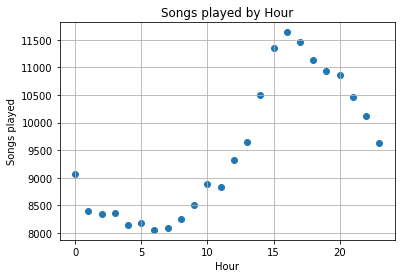

In [18]:
# plot songs played by hour
plt.scatter(songs_in_hour_pd['hour'], songs_in_hour_pd['count'])
plt.title("Songs played by Hour")
plt.xlabel("Hour")
plt.ylabel("Songs played");
plt.grid();

In [19]:
# songs in days
songs_in_days = user_log.filter(user_log.page == "NextSong").groupby(user_log.day).count().orderBy(user_log.day.cast("float"))
songs_in_days.show()

+---+-----+
|day|count|
+---+-----+
|  1| 9187|
|  2| 9646|
|  3| 6411|
|  4| 5729|
|  5| 6866|
|  6| 6796|
|  7| 5917|
|  8| 7390|
|  9| 9217|
| 10| 7791|
| 11| 6849|
| 12| 7314|
| 13| 6465|
| 14| 5876|
| 15| 8947|
| 16| 9056|
| 17| 6243|
| 18| 6292|
| 19| 8389|
| 20| 8995|
+---+-----+
only showing top 20 rows



In [20]:
# transform to Pandas dataframe
songs_in_days_pd = songs_in_days.toPandas()
songs_in_days_pd.day = pd.to_numeric(songs_in_days_pd.day)

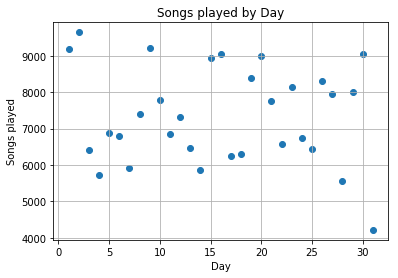

In [21]:
# plot songs played by day
plt.scatter(songs_in_days_pd['day'], songs_in_days_pd['count'])
plt.title("Songs played by Day")
plt.xlabel("Day")
plt.ylabel("Songs played");
plt.grid();

In [22]:
# drop rows with missing values
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
user_log_valid.count()

286500

In [24]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")
user_log_valid.count()

278154

Only empty strings as `userId` were removed. There wasn't missing values in `userId` or `sessionId` columns. 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [25]:
# filter by `Cancellation Confirmation`
user_log_valid.filter("page == 'Cancellation Confirmation'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+---+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|day|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+---+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|  20|  7|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033

In [26]:
# number of cancellations
user_log_valid.filter("page == 'Cancellation Confirmation'").select('userId').dropDuplicates().count()

52

In [27]:
# Kayla user service activity
Kayla_log = user_log_valid.select(['userId', 'sessionId', 'firstName', 'page', 'level', 'song', 'hour']).where(user_log.userId == '17')
Kayla_log.show()

+------+---------+---------+-----------+-----+--------------------+----+
|userId|sessionId|firstName|       page|level|                song|hour|
+------+---------+---------+-----------+-----+--------------------+----+
|    17|      250|    Kayla|       Home| free|                null|   5|
|    17|      250|    Kayla|   NextSong| free|      Pork And Beans|   5|
|    17|      250|    Kayla|   NextSong| free|Pursuit Of Happin...|   5|
|    17|      250|    Kayla|   NextSong| free|     God Isn't Dead?|   5|
|    17|      250|    Kayla|   NextSong| free|        By My Spirit|   5|
|    17|      250|    Kayla|   NextSong| free|Best Imitation Of...|   5|
|    17|      250|    Kayla|   NextSong| free|Language Lessons ...|   5|
|    17|      250|    Kayla|Roll Advert| free|                null|   5|
|    17|      250|    Kayla|   NextSong| free|Tavallaan jokaine...|   5|
|    17|      250|    Kayla|   NextSong| free|   Alive (nightmare)|   6|
|    17|      250|    Kayla|Roll Advert| free|     

In [40]:
# churn event
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
user_churn = user_log_valid.withColumn("pre_churn", flag_churn_event("page"))
user_churn = user_churn.withColumn('churn', Fmax('pre_churn').over(Window.partitionBy('userId')))
user_churn = user_churn.dropDuplicates(['userId'])

In [44]:
# table of churn
user_churn.groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [45]:
# user_churn to Pandas
user_churn_pd = user_churn.toPandas()

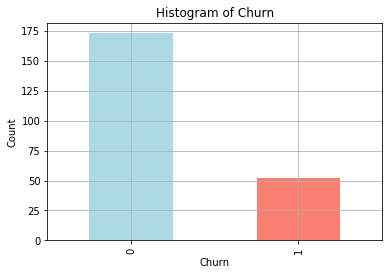

In [65]:
# hist of churn
user_churn_pd['churn'].value_counts().plot(kind="bar", color=["lightblue", "salmon"])
plt.title("Histogram of Churn")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.grid();

There are 52 churns and 173 no-churn users.

In [57]:
# table of gender
user_churn.groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



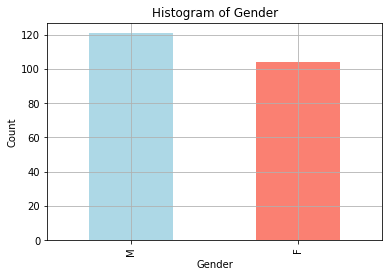

In [64]:
# hist of gender
user_churn_pd['gender'].value_counts().plot(kind="bar", color=["lightblue", "salmon"])
plt.title("Histogram of Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.grid();

There are 104 female and 121 male.

In [59]:
# table of level
user_churn_pd['level'].value_counts()

free    177
paid     48
Name: level, dtype: int64

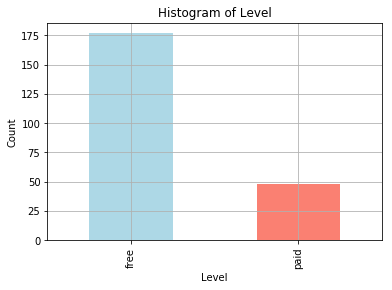

In [66]:
# plot of level
user_churn_pd['level'].value_counts().plot(kind="bar", color=["lightblue", "salmon"])
plt.title("Histogram of Level")
plt.xlabel("Level")
plt.ylabel("Count")
plt.grid();

There are 177 free and 48 paid.

In [58]:
# table of level vs gender
pd.crosstab(user_churn_pd.level, user_churn_pd.gender)

gender,F,M
level,,
free,77,100
paid,27,21


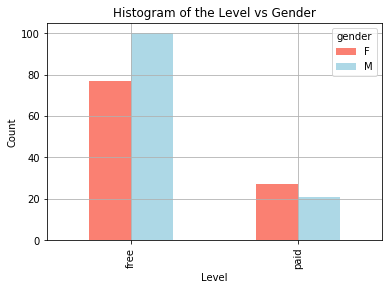

In [48]:
# plot the hist of level vs gender
pd.crosstab(user_churn_pd.level, user_churn_pd.gender).plot(kind="bar",
                                    color=["salmon", "lightblue"])
plt.title("Histogram of the Level vs Gender")
plt.xlabel("Level")
plt.ylabel("Count")
plt.grid();


In [67]:
# table of churn vs gender
pd.crosstab(user_churn_pd.churn, user_churn_pd.gender)

gender,F,M
churn,,
0,84,89
1,20,32


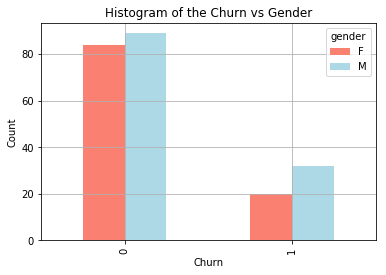

In [52]:
# hist of churn vs gender
pd.crosstab(user_churn_pd.churn, user_churn_pd.gender).plot(kind="bar",
                                    color=["salmon", "lightblue"])
plt.title("Histogram of the Churn vs Gender")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.grid();

In [90]:
# table of churn vs level
pd.crosstab(user_churn_pd.churn, user_churn_pd.level)

level,free,paid
churn,,
0,133,40
1,44,8


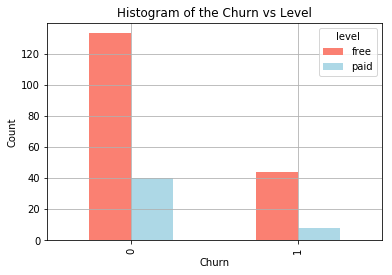

In [92]:
# hist of churn vs gender
pd.crosstab(user_churn_pd.churn, user_churn_pd.level).plot(kind="bar",
                                    color=["salmon", "lightblue"])
plt.title("Histogram of the Churn vs Level")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.grid();

In [69]:
# table of location - topten
user_churn_pd['location'].value_counts().head(10)

Los Angeles-Long Beach-Anaheim, CA             16
New York-Newark-Jersey City, NY-NJ-PA          15
Phoenix-Mesa-Scottsdale, AZ                     7
Dallas-Fort Worth-Arlington, TX                 7
St. Louis, MO-IL                                6
Chicago-Naperville-Elgin, IL-IN-WI              6
Charlotte-Concord-Gastonia, NC-SC               6
Boston-Cambridge-Newton, MA-NH                  5
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD     5
Miami-Fort Lauderdale-West Palm Beach, FL       5
Name: location, dtype: int64

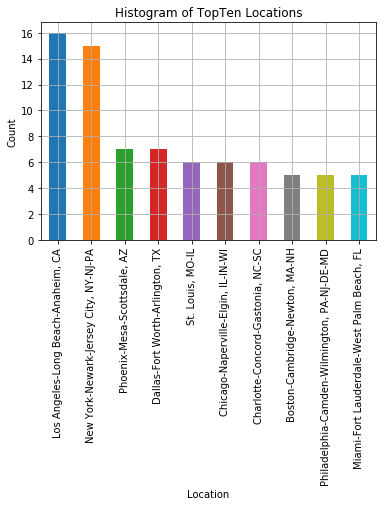

In [89]:
# hist of location
user_churn_pd['location'].value_counts().head(10).plot(kind="bar")
plt.title("Histogram of TopTen Locations")
plt.xlabel("Location")
plt.ylabel("Count")
plt.grid();

Los Angeles, New York and Phoenix are in the top three cities. 

In [59]:
# create temp table
user_log_valid.createOrReplaceTempView("log_table")

# create churn column
churn_df = spark.sql(
'''
    SELECT users.userId, 
    CASE WHEN CAST(churned.userId AS INT) IS NULL THEN 0
    ELSE 1 END AS churned
    FROM (
        SELECT DISTINCT CAST(userId AS INT)
        FROM log_table
        ORDER BY userId
    ) AS users
    FULL OUTER JOIN (
        SELECT CAST(log_table.userId AS INT)
        FROM log_table
        WHERE page = 'Cancellation Confirmation'
        ORDER BY userId
    ) AS churned
    ON users.userId = churned.userId
    ORDER BY userId
'''
)

churn_df.show()

+------+-------+
|userId|churned|
+------+-------+
|     2|      0|
|     3|      1|
|     4|      0|
|     5|      0|
|     6|      0|
|     7|      0|
|     8|      0|
|     9|      0|
|    10|      0|
|    11|      0|
|    12|      1|
|    13|      0|
|    14|      0|
|    15|      0|
|    16|      0|
|    17|      1|
|    18|      1|
|    19|      0|
|    20|      0|
|    21|      0|
+------+-------+
only showing top 20 rows



In [60]:
# how many churn (1) / not-churn(0) are there
churn_df.groupBy('churned').count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      1|   52|
|      0|  173|
+-------+-----+



In [61]:
# churn_df size
churn_df.count()

225

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [26]:
# pages available

spark.sql('''
          SELECT DISTINCT page
          FROM log_table 
          ORDER BY page ASC
          '''
          ).show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



### Feature 1:

In [27]:
# table to create a boolean feature related to gender
gender = spark.sql(
    '''
    SELECT CAST(userId AS INT),
    CASE WHEN gender = 'M' THEN 0 ELSE 1 END AS gender
    FROM log_table
    GROUP BY userId, gender
    ORDER BY userId, gender
    '''
)

gender.show(10)

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
|100004|     1|
|100005|     0|
|100006|     1|
|100007|     1|
|100008|     1|
+------+------+
only showing top 10 rows



In [28]:
# join gender with churn_df
churn_df = churn_df.join(gender, on='userId', how='left').fillna(0.0)
churn_df.show()

+------+-------+------+
|userId|churned|gender|
+------+-------+------+
|     2|      0|     1|
|     3|      1|     0|
|     4|      0|     0|
|     5|      0|     0|
|     6|      0|     0|
|     7|      0|     0|
|     8|      0|     1|
|     9|      0|     0|
|    10|      0|     0|
|    11|      0|     1|
|    12|      1|     1|
|    13|      0|     1|
|    14|      0|     0|
|    15|      0|     0|
|    16|      0|     1|
|    17|      1|     1|
|    18|      1|     0|
|    19|      0|     1|
|    20|      0|     1|
|    21|      0|     0|
+------+-------+------+
only showing top 20 rows



### Feature 2:

In [29]:
# table to count the number of total add friends per userId
total_friends = spark.sql(
    '''
    WITH h AS (
        SELECT CAST(userId AS INT)
        FROM log_table
        WHERE page = 'Add Friend'
        ORDER BY userId
    )
    SELECT 
        h.userId,
        COUNT(*) AS total_friends
    FROM h
    GROUP BY userId
    ORDER BY userId
    '''
)

total_friends.show(10)

+------+-------------+
|userId|total_friends|
+------+-------------+
|     2|           20|
|     3|            1|
|     4|           46|
|     5|            3|
|     6|           41|
|     7|            1|
|     8|            5|
|     9|           40|
|    10|           12|
|    11|            6|
+------+-------------+
only showing top 10 rows



In [30]:
# join total_friends with churn_df
churn_df = churn_df.join(total_friends, on='userId', how='left').fillna(0.0)
churn_df.show()

+------+-------+------+-------------+
|userId|churned|gender|total_friends|
+------+-------+------+-------------+
|     2|      0|     1|           20|
|     3|      1|     0|            1|
|     4|      0|     0|           46|
|     5|      0|     0|            3|
|     6|      0|     0|           41|
|     7|      0|     0|            1|
|     8|      0|     1|            5|
|     9|      0|     0|           40|
|    10|      0|     0|           12|
|    11|      0|     1|            6|
|    12|      1|     1|           13|
|    13|      0|     1|           32|
|    14|      0|     0|           19|
|    15|      0|     0|           31|
|    16|      0|     1|           10|
|    17|      1|     1|           12|
|    18|      1|     0|           10|
|    19|      0|     1|            4|
|    20|      0|     1|           25|
|    21|      0|     0|            8|
+------+-------+------+-------------+
only showing top 20 rows



### Feature 3:

In [31]:
# table to count the number of total hours per userId
hours_user = spark.sql(
'''
    WITH h AS (
        SELECT
            CAST(userId AS INT),
            CAST(hour AS INT) AS hour
        FROM log_table
        ORDER BY userId, hour
    )
    SELECT 
        h.userId,
        COUNT(h.hour) AS total_hours
    FROM h
    GROUP BY userId
    ORDER BY userId
'''
)

hours_user.show()

+------+-----------+
|userId|total_hours|
+------+-----------+
|     2|        899|
|     3|        254|
|     4|       2442|
|     5|        218|
|     6|       3761|
|     7|        201|
|     8|        334|
|     9|       3191|
|    10|        795|
|    11|        848|
|    12|       1064|
|    13|       1654|
|    14|       1432|
|    15|       2278|
|    16|        819|
|    17|       1102|
|    18|        513|
|    19|        259|
|    20|       2195|
|    21|        589|
+------+-----------+
only showing top 20 rows



In [32]:
# join hours_user with churn_df
churn_df = churn_df.join(hours_user, on='userId', how='left').fillna(0.0)
churn_df.show()

+------+-------+------+-------------+-----------+
|userId|churned|gender|total_friends|total_hours|
+------+-------+------+-------------+-----------+
|     2|      0|     1|           20|        899|
|     3|      1|     0|            1|        254|
|     4|      0|     0|           46|       2442|
|     5|      0|     0|            3|        218|
|     6|      0|     0|           41|       3761|
|     7|      0|     0|            1|        201|
|     8|      0|     1|            5|        334|
|     9|      0|     0|           40|       3191|
|    10|      0|     0|           12|        795|
|    11|      0|     1|            6|        848|
|    12|      1|     1|           13|       1064|
|    13|      0|     1|           32|       1654|
|    14|      0|     0|           19|       1432|
|    15|      0|     0|           31|       2278|
|    16|      0|     1|           10|        819|
|    17|      1|     1|           12|       1102|
|    18|      1|     0|           10|        513|


### Feature 4:

In [33]:
# table to count the number of total days per userId
days_user = spark.sql(
'''
    WITH d AS (
        SELECT DISTINCT
            CAST(userId AS INT),
            DATE(TIMESTAMP(ts)) AS date
        FROM log_table
        ORDER BY userId, date
    )
    SELECT 
        d.userId,
        COUNT(d.date) AS total_days
    FROM d
    GROUP BY userId
    ORDER BY userId
'''
)

days_user.show()

+------+----------+
|userId|total_days|
+------+----------+
|     2|       782|
|     3|       230|
|     4|      2133|
|     5|       171|
|     6|      3335|
|     7|       170|
|     8|       259|
|     9|      2760|
|    10|       699|
|    11|       667|
|    12|       955|
|    13|      1364|
|    14|      1244|
|    15|      1995|
|    16|       715|
|    17|       999|
|    18|       446|
|    19|       228|
|    20|      1900|
|    21|       519|
+------+----------+
only showing top 20 rows



In [34]:
# join days_user with churn_df
churn_df = churn_df.join(days_user, on='userId', how='left').fillna(0.0)
churn_df.show()

+------+-------+------+-------------+-----------+----------+
|userId|churned|gender|total_friends|total_hours|total_days|
+------+-------+------+-------------+-----------+----------+
|     2|      0|     1|           20|        899|       782|
|     3|      1|     0|            1|        254|       230|
|     4|      0|     0|           46|       2442|      2133|
|     5|      0|     0|            3|        218|       171|
|     6|      0|     0|           41|       3761|      3335|
|     7|      0|     0|            1|        201|       170|
|     8|      0|     1|            5|        334|       259|
|     9|      0|     0|           40|       3191|      2760|
|    10|      0|     0|           12|        795|       699|
|    11|      0|     1|            6|        848|       667|
|    12|      1|     1|           13|       1064|       955|
|    13|      0|     1|           32|       1654|      1364|
|    14|      0|     0|           19|       1432|      1244|
|    15|      0|     0| 

### Feature 5:

In [35]:
# table to count the number of total songs per userId
songs_user = spark.sql(
    '''
    WITH s AS (
        SELECT CAST(userId AS INT)
        FROM log_table
        WHERE page = 'NextSong'
        ORDER BY userId
    )
    SELECT 
        s.userId,
        COUNT(*) AS total_songs
    FROM s
    GROUP BY userId
    ORDER BY userId
    '''
)

songs_user.show()

+------+-----------+
|userId|total_songs|
+------+-----------+
|     2|        755|
|     3|        214|
|     4|       2048|
|     5|        161|
|     6|       3159|
|     7|        150|
|     8|        251|
|     9|       2676|
|    10|        673|
|    11|        647|
|    12|        867|
|    13|       1280|
|    14|       1230|
|    15|       1914|
|    16|        675|
|    17|        927|
|    18|        429|
|    19|        216|
|    20|       1807|
|    21|        499|
+------+-----------+
only showing top 20 rows



In [36]:
# join songs_user with churn_df
churn_df = churn_df.join(songs_user, on='userId', how='left').fillna(0.0)
churn_df.show()

+------+-------+------+-------------+-----------+----------+-----------+
|userId|churned|gender|total_friends|total_hours|total_days|total_songs|
+------+-------+------+-------------+-----------+----------+-----------+
|     2|      0|     1|           20|        899|       782|        755|
|     3|      1|     0|            1|        254|       230|        214|
|     4|      0|     0|           46|       2442|      2133|       2048|
|     5|      0|     0|            3|        218|       171|        161|
|     6|      0|     0|           41|       3761|      3335|       3159|
|     7|      0|     0|            1|        201|       170|        150|
|     8|      0|     1|            5|        334|       259|        251|
|     9|      0|     0|           40|       3191|      2760|       2676|
|    10|      0|     0|           12|        795|       699|        673|
|    11|      0|     1|            6|        848|       667|        647|
|    12|      1|     1|           13|       1064|  

### Feature 6:

In [37]:
# table to count the ratio of interactions per hour per day
interact_ratio_avg = spark.sql(
    '''
    WITH i AS (
        SELECT
            CAST(userId AS INT),
            DATE_TRUNC('HOUR', DATE(TIMESTAMP(ts))) AS hour,
            COUNT(*) AS num_interact
        FROM log_table
        GROUP BY userId, 2
        ORDER BY userId, 2
    )
    SELECT 
        i.userId,
        ROUND(AVG(i.num_interact), 2) AS interact_ratio
    FROM i
    GROUP BY userId
    ORDER BY userId
    '''
)

interact_ratio_avg.show()

+------+--------------+
|userId|interact_ratio|
+------+--------------+
|     2|          1.15|
|     3|           1.1|
|     4|          1.14|
|     5|          1.27|
|     6|          1.13|
|     7|          1.18|
|     8|          1.29|
|     9|          1.16|
|    10|          1.14|
|    11|          1.27|
|    12|          1.11|
|    13|          1.21|
|    14|          1.15|
|    15|          1.14|
|    16|          1.15|
|    17|           1.1|
|    18|          1.15|
|    19|          1.14|
|    20|          1.16|
|    21|          1.13|
+------+--------------+
only showing top 20 rows



In [38]:
# join interact_ratio_avg with churn_df
churn_df = churn_df.join(interact_ratio_avg, on='userId', how='left').fillna(0.0)
churn_df.show()

+------+-------+------+-------------+-----------+----------+-----------+--------------+
|userId|churned|gender|total_friends|total_hours|total_days|total_songs|interact_ratio|
+------+-------+------+-------------+-----------+----------+-----------+--------------+
|     2|      0|     1|           20|        899|       782|        755|          1.15|
|     3|      1|     0|            1|        254|       230|        214|           1.1|
|     4|      0|     0|           46|       2442|      2133|       2048|          1.14|
|     5|      0|     0|            3|        218|       171|        161|          1.27|
|     6|      0|     0|           41|       3761|      3335|       3159|          1.13|
|     7|      0|     0|            1|        201|       170|        150|          1.18|
|     8|      0|     1|            5|        334|       259|        251|          1.29|
|     9|      0|     0|           40|       3191|      2760|       2676|          1.16|
|    10|      0|     0|         

### Feature 7:

In [39]:
# table to count the number of days since join
join_days = spark.sql(
    '''
    WITH t2 AS (
        SELECT 
            t1.userId,
            t1.date,
            ROW_NUMBER() OVER (
                PARTITION BY t1.userId
                ORDER BY t1.date ASC
            ) AS row_num_1,
            ROW_NUMBER() OVER (
                PARTITION BY t1.userId
                ORDER BY t1.date DESC
            ) AS row_num_2
        FROM (
            SELECT DISTINCT
                CAST(log_table.userId AS INT) AS userId,
                DATE(TIMESTAMP(log_table.ts)) AS date
            FROM log_table
            ORDER BY 1, 2
        ) AS t1
        ORDER BY 1, 2
    ),
    t3 AS (
        SELECT
            t2.userId,
            t2.date
        FROM t2
        WHERE t2.row_num_1 = 1
    ),
    t4 AS (
        SELECT
            t2.userId,
            t2.date
        FROM t2
        WHERE t2.row_num_2 = 1
    )
    SELECT
        t3.userId,
        DATEDIFF(t4.date, t3.date) AS days_since_joining
    FROM t3
    INNER JOIN t4
    ON t3.userId = t4.userId
    ORDER BY 1
    '''
)

join_days.show()

+------+------------------+
|userId|days_since_joining|
+------+------------------+
|     2|             44736|
|     3|             27118|
|     4|             60636|
|     5|             35368|
|     6|             59317|
|     7|             50784|
|     8|             50919|
|     9|             60594|
|    10|             42437|
|    11|             53241|
|    12|             19207|
|    13|             59498|
|    14|             49717|
|    15|             54773|
|    16|             57063|
|    17|             10673|
|    18|              5139|
|    19|               628|
|    20|             57521|
|    21|             33666|
+------+------------------+
only showing top 20 rows



In [40]:
# join join_days with churn_df
churn_df = churn_df.join(join_days, on='userId', how='left').fillna(0.0)
churn_df.show()

+------+-------+------+-------------+-----------+----------+-----------+--------------+------------------+
|userId|churned|gender|total_friends|total_hours|total_days|total_songs|interact_ratio|days_since_joining|
+------+-------+------+-------------+-----------+----------+-----------+--------------+------------------+
|   148|      0|     0|            7|        518|       422|        398|          1.23|             55372|
|    85|      0|     0|           58|       4370|      3833|       3616|          1.14|             59016|
|   137|      0|     0|            8|        209|       166|        154|          1.26|             54318|
|    65|      0|     0|           53|       2544|      2225|       2113|          1.14|             58729|
|200001|      1|     0|            0|        158|       124|        115|          1.27|             14189|
|    53|      1|     0|           25|       2064|      1778|       1746|          1.16|             48752|
|   133|      0|     0|            1|

### Feature 8:

In [41]:
# table to count the number of thumbs down per day
thumbs_down = spark.sql(
    '''
    SELECT 
        CAST(userId AS INT) AS userId, 
        COUNT(*) AS thumbs_down
    FROM log_table
    WHERE page = 'Thumbs Down'
    GROUP BY CAST(userId AS INT)
    ORDER BY CAST(userId AS INT)
    '''
)

thumbs_down.show()

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|     2|          6|
|     3|          3|
|     4|         26|
|     6|         31|
|     7|          1|
|     8|          3|
|     9|         32|
|    10|          4|
|    11|          9|
|    12|          9|
|    13|         14|
|    14|         12|
|    15|         14|
|    16|          4|
|    17|         13|
|    18|          1|
|    19|          2|
|    20|         21|
|    21|          2|
|    23|          6|
+------+-----------+
only showing top 20 rows



In [42]:
# join thumbs_down with churn_df
churn_df = churn_df.join(thumbs_down, on='userId', how='left').fillna(0.0)
churn_df.show()

+------+-------+------+-------------+-----------+----------+-----------+--------------+------------------+-----------+
|userId|churned|gender|total_friends|total_hours|total_days|total_songs|interact_ratio|days_since_joining|thumbs_down|
+------+-------+------+-------------+-----------+----------+-----------+--------------+------------------+-----------+
|   148|      0|     0|            7|        518|       422|        398|          1.23|             55372|          3|
|    85|      0|     0|           58|       4370|      3833|       3616|          1.14|             59016|         38|
|   137|      0|     0|            8|        209|       166|        154|          1.26|             54318|          1|
|    65|      0|     0|           53|       2544|      2225|       2113|          1.14|             58729|         17|
|200001|      1|     0|            0|        158|       124|        115|          1.27|             14189|          1|
|    53|      1|     0|           25|       2064

### Feature 9:

In [43]:
# table to count the number of thumbs up per day
thumbs_up = spark.sql(
    '''
    SELECT 
        CAST(userId AS INT) AS userId, 
        COUNT(*) AS thumbs_up
    FROM log_table
    WHERE page = 'Thumbs Up'
    GROUP BY CAST(userId AS INT)
    ORDER BY CAST(userId AS INT)
    '''
)

thumbs_up.show()

+------+---------+
|userId|thumbs_up|
+------+---------+
|     2|       29|
|     3|       14|
|     4|       95|
|     5|       11|
|     6|      165|
|     7|        7|
|     8|       16|
|     9|      118|
|    10|       37|
|    11|       40|
|    12|       42|
|    13|       57|
|    14|       54|
|    15|       81|
|    16|       42|
|    17|       40|
|    18|       20|
|    19|        5|
|    20|      106|
|    21|       27|
+------+---------+
only showing top 20 rows



In [44]:
# join thumbs_up with churn_df
churn_df = churn_df.join(thumbs_up, on='userId', how='left').fillna(0.0)
churn_df.show()

+------+-------+------+-------------+-----------+----------+-----------+--------------+------------------+-----------+---------+
|userId|churned|gender|total_friends|total_hours|total_days|total_songs|interact_ratio|days_since_joining|thumbs_down|thumbs_up|
+------+-------+------+-------------+-----------+----------+-----------+--------------+------------------+-----------+---------+
|   148|      0|     0|            7|        518|       422|        398|          1.23|             55372|          3|       28|
|    85|      0|     0|           58|       4370|      3833|       3616|          1.14|             59016|         38|      192|
|   137|      0|     0|            8|        209|       166|        154|          1.26|             54318|          1|        8|
|    65|      0|     0|           53|       2544|      2225|       2113|          1.14|             58729|         17|      111|
|200001|      1|     0|            0|        158|       124|        115|          1.27|          

### Feature 10:

In [45]:
# table to count the number of add to playlist per day
add_playlist = spark.sql(
    '''
    SELECT 
        CAST(userId AS INT) AS userId, 
        COUNT(*) AS add_playlist
    FROM log_table
    WHERE page = 'Add to Playlist'
    GROUP BY CAST(userId AS INT)
    ORDER BY CAST(userId AS INT)
    '''
)

add_playlist.show()

+------+------------+
|userId|add_playlist|
+------+------------+
|     2|          13|
|     3|           4|
|     4|          59|
|     5|           8|
|     6|          83|
|     7|           5|
|     8|           6|
|     9|          77|
|    10|           9|
|    11|          20|
|    12|          19|
|    13|          37|
|    14|          34|
|    15|          59|
|    16|          19|
|    17|          30|
|    18|          14|
|    19|           8|
|    20|          54|
|    21|           9|
+------+------------+
only showing top 20 rows



In [46]:
# join add_playlist with churn_df
churn_df = churn_df.join(add_playlist, on='userId', how='left').fillna(0.0)
churn_df.show()

+------+-------+------+-------------+-----------+----------+-----------+--------------+------------------+-----------+---------+------------+
|userId|churned|gender|total_friends|total_hours|total_days|total_songs|interact_ratio|days_since_joining|thumbs_down|thumbs_up|add_playlist|
+------+-------+------+-------------+-----------+----------+-----------+--------------+------------------+-----------+---------+------------+
|   148|      0|     0|            7|        518|       422|        398|          1.23|             55372|          3|       28|           5|
|    85|      0|     0|           58|       4370|      3833|       3616|          1.14|             59016|         38|      192|         108|
|   137|      0|     0|            8|        209|       166|        154|          1.26|             54318|          1|        8|           4|
|    65|      0|     0|           53|       2544|      2225|       2113|          1.14|             58729|         17|      111|          68|
|20000

### Feature 11:

In [47]:
# table to create a boolean feature related to the level
level = spark.sql(
    '''
    SELECT CAST(userId AS INT),
    CASE WHEN level = 'free' THEN 0 ELSE 1 END AS level
    FROM log_table
    GROUP BY userId, level
    ORDER BY userId, level
    '''
)

level.show(10)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    0|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    0|
|100004|    1|
|100005|    0|
|100006|    0|
+------+-----+
only showing top 10 rows



In [48]:
# join level with churn_df
churn_df = churn_df.join(level, on='userId', how='left').fillna(0.0)
churn_df.show()

+------+-------+------+-------------+-----------+----------+-----------+--------------+------------------+-----------+---------+------------+-----+
|userId|churned|gender|total_friends|total_hours|total_days|total_songs|interact_ratio|days_since_joining|thumbs_down|thumbs_up|add_playlist|level|
+------+-------+------+-------------+-----------+----------+-----------+--------------+------------------+-----------+---------+------------+-----+
|   148|      0|     0|            7|        518|       422|        398|          1.23|             55372|          3|       28|           5|    0|
|    85|      0|     0|           58|       4370|      3833|       3616|          1.14|             59016|         38|      192|         108|    1|
|    85|      0|     0|           58|       4370|      3833|       3616|          1.14|             59016|         38|      192|         108|    0|
|   137|      0|     0|            8|        209|       166|        154|          1.26|             54318|      

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [49]:
# features type
churn_df.dtypes

[('userId', 'int'),
 ('churned', 'int'),
 ('gender', 'int'),
 ('total_friends', 'bigint'),
 ('total_hours', 'bigint'),
 ('total_days', 'bigint'),
 ('total_songs', 'bigint'),
 ('interact_ratio', 'double'),
 ('days_since_joining', 'int'),
 ('thumbs_down', 'bigint'),
 ('thumbs_up', 'bigint'),
 ('add_playlist', 'bigint'),
 ('level', 'int')]

In [50]:
# VectorAssembler to combine features
assembler = VectorAssembler(
    inputCols=[col for col in churn_df.columns if col not in ['userId', 'churned']], 
    outputCol='unscaled_features')

data = assembler \
    .transform(churn_df) \
    .select(
        col('userId'),
        col('churned').alias('label'), 
        col('unscaled_features')
    )

# split the dataset
train, test = data.randomSplit([0.8, 0.2], seed=42)


In [51]:
# scaler
train_scaler = StandardScaler(
    inputCol='unscaled_features', 
    outputCol='features'
)

train = train_scaler.fit(train).transform(train)
test = train_scaler.fit(test).transform(test)

### Logistic Regression

In [52]:
# Init Logistic Regression
lr_clf = LogisticRegression()

lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr_clf.regParam, [0.1, 0.01]) \
    .build()

# cross_validation
lr_crossval = CrossValidator(
    estimator=lr_clf,
    estimatorParamMaps=lr_paramGrid,
    evaluator=BinaryClassificationEvaluator(),
    numFolds=5
)

# fitting
lr_cvModel = lr_crossval.fit(train)


In [ ]:
# predictions
lr_prediction = lr_cvModel.transform(test)

In [55]:
print('Accuracy: {}%'.format(
    lr_prediction.filter(lr_prediction.label == lr_prediction.prediction).count() * 100 / lr_prediction.count())
)


Accuracy: 77.14285714285714%


In [56]:
# dataset to a pandas df
lr_prediction_df = lr_prediction.select(['userId', 'label', 'probability', 'prediction']).toPandas()


In [57]:
lr_user_churn_probabilities = lr_prediction_df[['userId', 'probability']]
lr_user_churn_probabilities.head()


,userId,probability
0,85,"[0.777577997624, 0.222422002376]"
1,137,"[0.756935258283, 0.243064741717]"
2,65,"[0.824910498306, 0.175089501694]"
3,133,"[0.212297060224, 0.787702939776]"
4,78,"[0.843330077736, 0.156669922264]"


In [60]:
# F1, precision and recall
lr_y_test_pred = lr_prediction_df['prediction']
lr_y_test_true = lr_prediction_df['label']

print({
    'f1_score': f1_score(y_true=lr_y_test_true, y_pred=lr_y_test_pred),
    'precision': precision_score(y_true=lr_y_test_true, y_pred=lr_y_test_pred),
    'recall': recall_score(y_true=lr_y_test_true, y_pred=lr_y_test_pred)
})


{'f1_score': 0.42857142857142855, 'precision': 0.375, 'recall': 0.5}


### Random Forest

In [52]:
# Init Random Forest
rf_clf = RandomForestClassifier()

rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf_clf.maxDepth, [2, 4, 6]) \
    .addGrid(rf_clf.maxBins, [20, 60]) \
    .addGrid(rf_clf.numTrees, [5, 20, 100]) \
    .build()

# cross-validation
rf_crossval = CrossValidator(
    estimator=rf_clf,
    estimatorParamMaps=rf_paramGrid,
    evaluator=BinaryClassificationEvaluator(),
    numFolds=5
)

# fitting
rf_cvModel = rf_crossval.fit(train)

In [ ]:
# predictions
rf_prediction = rf_cvModel.transform(test)

In [55]:
# Accuracy
print('Accuracy: {}%'.format(
    rf_prediction.filter(rf_prediction.label == rf_prediction.prediction).count() * 100 / rf_prediction.count())
)


Accuracy: 82.85714285714286%


In [56]:
# dataset to a pandas df
rf_prediction_df = rf_prediction.select(['userId', 'label', 'probability', 'prediction']).toPandas()


In [57]:
rf_user_churn_probabilities = rf_prediction_df[['userId', 'probability']]
rf_user_churn_probabilities.head()


,userId,probability
0,85,"[0.949027369826, 0.0509726301736]"
1,137,"[0.893574542746, 0.106425457254]"
2,65,"[0.976927122453, 0.023072877547]"
3,133,"[0.309410648768, 0.690589351232]"
4,78,"[0.841313820964, 0.158686179036]"


In [58]:
# F1, precision and recall
rf_y_test_pred = rf_prediction_df['prediction']
rf_y_test_true = rf_prediction_df['label']

print({
    'f1_score': f1_score(y_true=rf_y_test_true, y_pred=rf_y_test_pred),
    'precision': precision_score(y_true=rf_y_test_true, y_pred=rf_y_test_pred),
    'recall': recall_score(y_true=rf_y_test_true, y_pred=rf_y_test_pred)
})


{'f1_score': 0.53846153846153844, 'precision': 0.5, 'recall': 0.58333333333333337}


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.